In [311]:
import pandas as pd
import os
import requests
import numpy as np
import operator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [138]:
df_pickle_path = "../../typealyzer-dataset/pickles/dataframe_survey_2018-01-23_enriched.pickle"

In [318]:
indata = pd.read_pickle(df_pickle_path)
indata.head(10)

,url,typealyzer,actual,e,s,t,sntf_s,sntf_n,sntf_t,sntf_f,...,percept,auxverb,article,leisure,achieve,sad,anger,discrep,negate,quant
0,http://jonkagstrom.com,ISTP,INFJ,0.420758,0.651605,0.652214,0.512359,0.274234,0.134025,0.079382,...,0.040162,0.125614,0.395001,0.021577,0.020508,0.003632,0.007904,0.012177,0.022217,0.048280
1,http://adropofcolour.tumblr.com,ISFP,INFJ,0.291281,0.787844,0.460961,0.663515,0.178565,0.069282,0.088638,...,0.036240,0.108720,0.326161,0.006795,0.023783,0.001133,0.005663,0.016988,0.041903,0.033975
2,http://godheadcomplex.tumblr.com,ESFP,INFP,0.883579,0.951693,0.238407,0.855921,0.046931,0.021850,0.075297,...,0.039409,0.147783,0.290640,0.014778,0.024631,0.000000,0.009852,0.014778,0.034483,0.024631
3,http://chaotikaeon2.tumblr.com,INTJ,INTP,0.332444,0.357863,0.591322,0.147668,0.252326,0.339831,0.260175,...,0.031524,0.084063,0.316988,0.021016,0.012259,0.000000,0.012259,0.015762,0.040280,0.029772
4,http://codeode.com,ESTJ,I don't know,0.556231,0.881763,0.969999,0.449375,0.065664,0.466337,0.018624,...,0.023108,0.123506,0.414343,0.023108,0.021514,0.002390,0.003984,0.009562,0.019124,0.035857
5,http://perpetually-in-transit.blogspot.com,ESFP,ENFJ,0.944394,0.943192,0.105527,0.778825,0.051134,0.017299,0.152742,...,0.040807,0.114916,0.415572,0.025797,0.018293,0.003283,0.006098,0.012195,0.017824,0.031895
6,http://www.chocolateannie.blogspot.com,ESFP,ENFP,0.816134,0.860018,0.051798,0.536634,0.090553,0.018246,0.354567,...,0.049020,0.173203,0.359477,0.039216,0.016340,0.003268,0.000000,0.032680,0.027778,0.055556
7,http://www.magnusljadas.se,ISTP,INFP,0.325755,0.588240,0.771802,0.449846,0.313740,0.177039,0.059374,...,0.040271,0.110745,0.329283,0.015449,0.021524,0.006422,0.011283,0.009373,0.024996,0.034369
8,http://www.medimoon.com,ISTJ,I don't know,0.455204,0.564765,0.993508,0.232624,0.179134,0.583645,0.004596,...,0.011331,0.138810,0.382436,0.008499,0.025496,0.000000,0.005666,0.002833,0.036827,0.019830
9,http://webfloss.com,ESTJ,INTJ,0.567693,0.995600,0.965974,0.183111,0.001682,0.784172,0.031035,...,0.027397,0.047945,0.294521,0.013699,0.006849,0.000000,0.000000,0.013699,0.006849,0.000000


In [140]:
len(indata[pd.isnull(indata["tokens"])])

0

In [317]:
indata[pd.isnull(indata.base_function)]

,ix,text,base_function,directed_function


# Inspect original data function distributions

In [142]:
s_series = indata[indata.is_s == 1]["tokens"]
n_series = indata[indata.is_n == 1]["tokens"]
t_series = indata[indata.is_t == 1]["tokens"]
f_series = indata[indata.is_f == 1]["tokens"]

avg_tkns = {
    "s":s_series.mean(),
    "n":n_series.mean(),
    "t":t_series.mean(),
    "f":f_series.mean()
}
avg_tkns

{'f': 562.2211350293542,
 'n': 586.8517534537726,
 's': 541.6055971363488,
 't': 589.1853771898462}

In [143]:
indata.func.value_counts()

n    11292
f     7154
t     5594
s     3073
Name: func, dtype: int64

# Sample equal size text chunks for training and evaluation data
Since the smallest subset ("s") contains 3073 texts (see above), I cut each class into 3000 observations.
See: [Pandas sample()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html)

In [144]:
# order: s,n,t,f
samples = pd.concat([
            indata[indata.is_s == 1].sample(3000)[["text","tokens","func","funcatt"]],
            indata[indata.is_n == 1].sample(3000)[["text","tokens","func","funcatt"]],
            indata[indata.is_t == 1].sample(3000)[["text","tokens","func","funcatt"]],
            indata[indata.is_f == 1].sample(3000)[["text","tokens","func","funcatt"]]
            ])

In [145]:
samples.head(3)

,text,tokens,func,funcatt
4789,"Oh Wait, I Am In Love About Me Ask RSS...",294,s,si
2449,Finding my way out of the abyss. Finding my wa...,155,s,si
17702,wat the fuck home / about / main shut up!!! FU...,106,s,si


In [146]:
samples.func.value_counts()

n    3000
s    3000
t    3000
f    3000
Name: func, dtype: int64

In [147]:
samples.to_pickle("jung_functions_samples_n3000.pickle")

# Setup uClassify classifer and prepare training and evaluation datasets
The variable `os.environ["UCLASSIFY_WRITE"]` is created by adding a line to e.g. `~/.profile`:

`export UCLASSIFY_WRITE = "<your_uclassify_write_key>"`

In [148]:
def setup_jung_functions_en_classes():
    """The classifier is already created manually at https://uclassify.com/manage/classifiers/Jung-Cognitive-Functions-En/.
    """
    for name in ["s","n","t","f"]:
        data = {"key":os.environ["UCLASSIFY_WRITE"],"className":name}
        header = {"Content-Type": "application/json",
                  "Authorization": "Token " + os.environ["UCLASSIFY_WRITE"]}

        response = requests.post('https://api.uclassify.com/v1/me/Jung-Cognitive-Functions-En/addClass', 
                        json = data,
                        headers = header)
    return print("name: {}, response: {}".format(name, response.content))

setup_jung_functions_en_classes()

name: f, response: b''


In [149]:
# prepare column to keep track of what's been used for training
zeros = np.zeros(len(samples))
samples["training_set"] = zeros
samples["training_set"] = samples.training_set.astype("int")
samples.head(3)

,text,tokens,func,funcatt,training_set
4789,"Oh Wait, I Am In Love About Me Ask RSS...",294,s,si,0
2449,Finding my way out of the abyss. Finding my wa...,155,s,si,0
17702,wat the fuck home / about / main shut up!!! FU...,106,s,si,0


Split samples into train and eval subsets.

In [150]:
traing_set_size = 2100 # e.g. 2100 is 70% of 3000 samples
s_train = samples[samples.func == "s"].sample(traing_set_size).index
n_train = samples[samples.func == "n"].sample(traing_set_size).index
t_train = samples[samples.func == "t"].sample(traing_set_size).index
f_train = samples[samples.func == "f"].sample(traing_set_size).index

sn_train = s_train.union(n_train)
tf_train = t_train.union(f_train)
sntf_train = sn_train.union(tf_train)

samples.loc[sntf_train, "training_set"] = 1
samples.head(15)

,text,tokens,func,funcatt,training_set
4789,"Oh Wait, I Am In Love About Me Ask RSS...",294,s,si,0
2449,Finding my way out of the abyss. Finding my wa...,155,s,si,0
17702,wat the fuck home / about / main shut up!!! FU...,106,s,si,0
16724,hit counter A Little Bit of Everything Sticks ...,464,s,se,1
24966,Drifting at the Roche Limit 1.5M ratings 277k ...,1425,s,se,1
14544,Prince of Time princessloon --> princessloon :...,422,s,se,1
2657,"Hipnecks Hipnecks Sunday, September 18, 2011 J...",100,s,si,0
25365,https://www.tumblr.com/themes/by/leentheme htt...,1189,s,si,0
6332,"Life is about eating, sleeping, and taking bat...",475,s,si,1
8570,"art, fanart and bad puns art, fanart and bad p...",131,s,si,1


# Train uClassify.com classifier

In [151]:
def train_jung_cognitive_functions_en_classes(name):
    """Presupposes that classifier is created and that setup_jung_functions_en_classes() is already run.
    name: expects one of ["s","n","t","f"]
    """
    trained_ix = []
    text_count = 1
    for ix, row in samples.loc[(samples.func == name) & (samples.training_set == 1)].iterrows():
        trained_ix.append(ix)
        data = {"texts":[row["text"]]}
        header = {"Content-Type": "application/json",
                 "Authorization": "Token " + os.environ["UCLASSIFY_WRITE"]}

        response = requests.post('https://api.uclassify.com/v1/me/Jung-Cognitive-Functions-En/' + name + "/train", 
                    json = data,
                    headers = header)
        print("{}:{}".format(name, text_count))
        text_count += 1
    print("Finished training Jung Cognitive Functions.")
    return trained_ix

Use the sampled texts to train each classifier class

In [ ]:
sntf_trained_ix = []
for name in ["s","n","t","f"]:
    functions_trained_ix = train_jung_cognitive_functions_en_classes(name)
    sntf_trained_ix.append(functions_trained_ix)

# Classify blog texts

In [206]:
def classify_jung_cognitive_function_of_text(text):
    """Does what it says, pretty much."""
    header = {"Content-Type": "application/json",
             "Authorization": "Token " + os.environ["UCLASSIFY_READ"]}
    data = {"texts":[text]} # send a one-item list for now, since we don't have a feel for sizes
    result = requests.post("https://api.uclassify.com/v1/prfekt/jung-cognitive-functions-en/classify",
                       json = data,
                       headers = header)
    json_result = result.json()
    
    res_dict = {"s":0, "n":0, "t":0, "f":0}
    
    for classItem in json_result[0]["classification"]:
        res_dict[classItem["className"]] = classItem["p"]
    
    sorted_dict = sorted(res_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_dict

In [291]:
# prepare column to keep track of what's been used for training
eval_set = samples[samples.training_set == 0]
eval_set.head(2)

,text,tokens,func,funcatt,training_set
4789,"Oh Wait, I Am In Love About Me Ask RSS...",294,s,si,0
2449,Finding my way out of the abyss. Finding my wa...,155,s,si,0


In [227]:
zeros = np.zeros(len(eval_set))
results = []
row_cnt = 1
for ix, row in eval_set.iterrows():
    print("row: {} of {}".format(row_cnt, len(eval_set)),end="\r")
    res = classify_jung_cognitive_function_of_text(row["text"])
    results.append(res[0][0])
    row_cnt += 1

In [207]:
# from https://wordpress.com/read/blogs/840468/posts/17785
a_text = """ 
The high temperature today almost reached my age and I just had
to get outside again and enjoy the east coast of Iowa. So I
checked out any critters flying about. This cardinal perched on
a branch and tried to figure me out.

After watching her watching me I looked up to find 2 flocks of
geese heading north. I took that as a good sign that perhaps
winter is almost behind us and spring is getting closer.

Then imagine my surprise when a huge flock of American White
pelicans flew overhead. There were too many to count and they
got here earlier this year. They were headed east, but hey,
they’re here. As always, you can click on the pictures to
enlarge them.

And finally, after these huge birds were done flying over a
bird of prey decided to take over the airspace. I believe it’s
some sort of hawk but not sure.

So I spent the day outside, missed all automated calls, and got
to relax. I’m working on figuring out how to get the coffee pot
to work while walking around outside. Perhaps a power inverter
and a small cart.

Some may call it wasted time, or avoiding work, but in my case
it’s therapy. No matter my mood, when the camera is in my hand
and a few pictures snapped I’m smiling. Having a nice day to
take pictures is an added blessing.

Enjoy our Tuesday as it has been a great one here.
Comments are always welcome."""

res = classify_jung_cognitive_function_of_text(a_text)
print(res)
#for classItem in res[0]["classification"]:
#    print(classItem["className"], classItem["p"])

[('n', 0.777895), ('f', 0.108428), ('t', 0.0575941), ('s', 0.0560828)]


In [292]:
eval_set = pd.concat([eval_set,pd.DataFrame(results, index=eval_set.index)], axis=1, ignore_index=True)
eval_set.columns = ["text","tokens","func","funcatt","training_set","uclassify"]
eval_set.head()

In [300]:
eval_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3600 entries, 4789 to 14075
Data columns (total 6 columns):
text            3600 non-null object
tokens          3600 non-null int64
func            3600 non-null object
funcatt         3600 non-null object
training_set    3600 non-null int64
uclassify       3600 non-null object
dtypes: int64(2), object(4)
memory usage: 196.9+ KB


# Classification report

In [301]:
cr = classification_report(eval_set['func'], eval_set['uclassify'])
print(cr)

             precision    recall  f1-score   support

          f       0.27      0.24      0.25       900
          n       0.25      0.26      0.26       900
          s       0.27      0.33      0.29       900
          t       0.27      0.24      0.25       900

avg / total       0.27      0.27      0.26      3600



In [313]:
classes=list(set(eval_set['uclassify'].values))
cm=pd.DataFrame(confusion_matrix(eval_set['func'].values,eval_set['uclassify'].values,labels=classes))
cm.columns=classes
cm.index=classes
cm

,s,f,t,n
s,293,188,199,220
f,269,217,182,232
t,267,186,212,235
n,268,220,179,233


In [ ]:
for ix, row in eval_set.iterrows():
    res = classify_jung_cognitive_function_of_text(row["text"])
    eval_set.loc[ix, "uclassify"] = res[]

In [219]:
eval_set = pd.concat([eval_set,pd.Series(results)], axis=1, ignore_index=True)

In [223]:
len(results)

3600

In [309]:
eval_set.groupby(['uclassify','func']).size()

uclassify  func
f          f       217
           n       220
           s       188
           t       186
n          f       232
           n       233
           s       220
           t       235
s          f       269
           n       268
           s       293
           t       267
t          f       182
           n       179
           s       199
           t       212
dtype: int64

In [303]:
actual = eval_set['func'].value_counts()
predicted = eval_set['uclassify'].value_counts()
compare = [(actual[i], predicted[i]) for i in predicted.index.values]

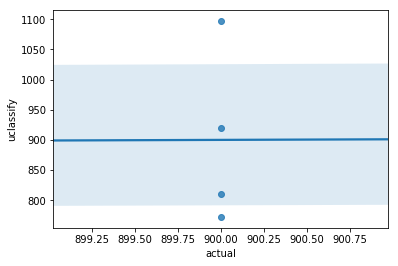

In [305]:
cmp = pd.DataFrame(compare)
cmp.index = predicted.index.values
cmp.columns = ['actual', 'uclassify']
sns.regplot(x=cmp['actual'],y=cmp['uclassify'])

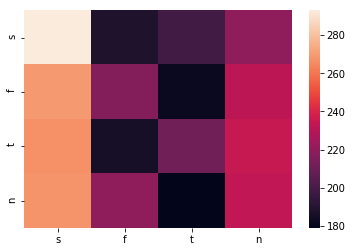

In [315]:
sns.heatmap(cm, annot=False)

# Conclusion and further reserach

* Not very impressive classification results. 

* Since Jungs cognitive functions are really dichotomies of sensing <-> intuition and thinking <-> feeling, two new classifiers should be created to see if results improve.

* Another important thing is that no pre-processing of the texts have been done. Use TF-IDF to separate out noice from relevant features?

